In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)

import Figure_H2H_Regret

from Performance import performance_evaluation
perfs = performance_evaluation()

from Performance import H2h_Regret_Evaluation
h2h_regret_eva = H2h_Regret_Evaluation()

from Data import Data_Simulator
DS_Obj = Data_Simulator()

from Oracle import Oracle_Processing
Oracle_Proc = Oracle_Processing()

from OLS import OLS_Processing
OLS_Proc = OLS_Processing()

from DDR import DDR_Processing
DDR_Proc = DDR_Processing()

from PYEPO import EPO_Processing
PYEPO_Proc = EPO_Processing()

from Data_Load_Store import Load_Store_Methods
Data_LSM = Load_Store_Methods()

In [2]:
import Baseline_Params 
import Sequential_Learning_Approaches as SLA

### Main functions

## Parameters

In [3]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(parent_directory)))
middle_path = '/Data_JOC_R1/Shortest_Path_Rep/Baseline_' + data_generation_process +"/"
working_dir = project_directory + middle_path
Result_dir = project_directory + middle_path + "Result/"
pathlib.Path(working_dir).mkdir(parents=True, exist_ok=True)
pathlib.Path(Result_dir).mkdir(parents=True, exist_ok=True)

In [5]:
num_train, num_feat, num_test, deg, e, lower, upper, p, alpha, mis, coef_seed, x_dist, e_dist, x_low, x_up, x_mean, x_var, bump, grid_all, iteration_all,mu_all,lamb_all = Baseline_Params.get_Params(working_dir)

### Comparison between DDR and OLS

In [8]:
h2h_ddr_vs_ols_ante = {}; cost_rd_ddr_vs_ols_ante = {}; regret_rd_ddr_vs_ols_ante = {}
for grid in grid_all:
    L_N = grid[0]
    DataPath_parent = project_directory + middle_path +str(L_N)+'by'+str(L_N)+'_grid/'
    DataPath = DataPath_parent + f"data_size={num_train}_deg={deg}_e={e}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    print("DataPath:", DataPath)     
    cost_Oracle_Ante_all,cost_OLS_Ante_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
    for mu in mu_all:
        for lamb in lamb_all:
            h2h_ddr_vs_ols_ante[L_N,mu,lamb],regret_rd_ddr_vs_ols_ante[L_N,mu,lamb] \
                = h2h_regret_eva.calculate_DDR_vs_Others_h2h_regret(mu,lamb,iteration_all,\
                                                                    cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    print("Grid = ",grid)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path_Rep/Baseline_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
Grid =  (3, 3)


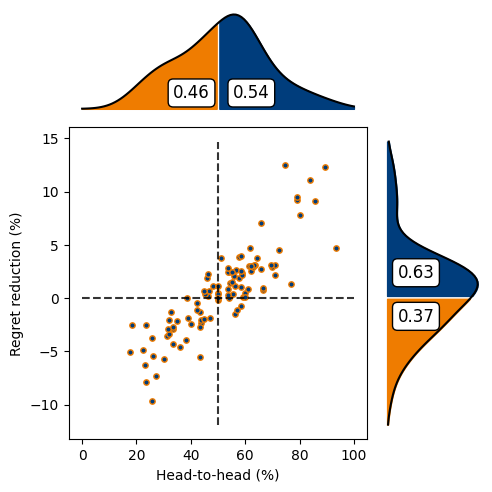

In [9]:
L_N = 3
mu = 0.75
lamb = 0.8
file_name = Result_dir + 'DDR_vs_OLS_mu='+str(mu)+"_lamb="+str(lamb)+"_ante_grid="+str(L_N)
all_x = h2h_ddr_vs_ols_ante[L_N,mu,lamb] * 100
all_y = regret_rd_ddr_vs_ols_ante[L_N,mu,lamb] * 100
Figure_H2H_Regret.figure_plot_upright(all_x, all_y, file_name, size = (5, 5), move = [-0.07, 0.07, 0.35, 0.55], ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)

### DDR vs SPO+

In [11]:
h2h_ddr_vs_spo_ante = {}; cost_rd_ddr_vs_spo_ante = {}; regret_rd_ddr_vs_spo_ante = {}
for grid in grid_all:
    L_N = grid[0]
    DataPath_parent = project_directory + middle_path +str(L_N)+'by'+str(L_N)+'_grid/'
    DataPath = DataPath_parent + f"data_size={num_train}_deg={deg}_e={e}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    print("DataPath:", DataPath)     
    cost_Oracle_Ante_all,cost_OLS_Ante_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
    with open(DataPath+'cost_spo+_Ante_all.pkl', "rb") as tf:
        cost_SPO_Ante_all = pickle.load(tf)
    for mu in mu_all:
        for lamb in lamb_all:
            h2h_ddr_vs_spo_ante[L_N,mu,lamb],regret_rd_ddr_vs_spo_ante[L_N,mu,lamb] \
                = h2h_regret_eva.calculate_DDR_vs_Others_h2h_regret(mu,lamb,iteration_all,\
                                                                    cost_DDR_Ante_all,cost_SPO_Ante_all,cost_Oracle_Ante_all)
    print("Grid = ",grid)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path_Rep/Baseline_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
Grid =  (3, 3)


In [ ]:
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import seaborn as sns
import matplotlib.pyplot as plt
def Upright_Figure(all_x, all_y, figure_name, size = (5, 5), move = [-0.07, 0.07, 0.35, 0.55], 
                        ymin = 0, ymax=100,xmin = 0,xmax = 100):
    
    data = np.asarray([all_x,all_y])

    ####### Obtain KDE  
    #KDE for top marginal
    kde_X = gaussian_kde(data[0])
    #KDE for right marginal
    kde_Y = gaussian_kde(data[1])

    x = np.linspace(0, 100, 100)
    y = np.linspace(ymin, ymax, 100)

    dx = kde_X(x) # X-marginal density
    dy = kde_Y(y) # Y-marginal density

    #Define grid for subplots
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios = [1, 3])

    ####### Create scatter plot
    fig = plt.figure(figsize = size)
    ax = plt.subplot(gs[1, 0])
    cax = ax.scatter(data[0], data[1], s = 15, color='#003D7C', marker = "o", edgecolors = "#EF7C00")
    plt.xlabel('Head-to-head (%)')

    plt.ylabel('Regret reduction (%)') #pio
    plt.vlines(50, ymin, ymax, linestyle="dashed", alpha = 0.8,color = 'k')
    plt.hlines(0, xmin, xmax, linestyle="dashed", alpha = 0.8,color = 'k')

    # ####### Create Y-marginal (right)
    axr = plt.subplot(gs[1, 1], xticks = [], yticks = [], frameon = False)
    axr.plot(dy, y, color = 'black')

    axr.fill_betweenx(y, 0, dy, where = y <= 0.01, alpha = 1, color='#EF7C00')
    axr.fill_betweenx(y, 0, dy, where = y >= 0, alpha = 1, color='#003D7C')

    leftarea = np.round( sum(n <= 0 for n in all_y)/len(all_y),2 )
    rightarea = np.round( sum(n > 0 for n in all_y)/len(all_y),2 )

    axr.annotate(leftarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[0]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
    axr.annotate(rightarea, xy=(0.15, abs(ymin)/(ymax - ymin) + move[1]), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

    # ####### Create X-marginal (top)
    axt = plt.subplot(gs[0,0], frameon = False, yticks = [], xticks = [])
    #base = pyplot.gca().transData
    #rot = transforms.Affine2D().rotate_deg(180)
    axt.plot(x, dx, color = 'black')
    axt.fill_between(x, 0, dx, where = x >= 49.9, alpha= 1, color = '#003D7C')
    axt.fill_between(x, 0, dx, where = x <= 50, alpha= 1, color = '#EF7C00')

    #     axt.invert_yaxis()
    leftarea = np.round( sum(n <= 50 for n in all_x)/len(all_x),2 )
    rightarea = np.round( sum(n > 50 for n in all_x)/len(all_x),2 )

    axt.annotate(leftarea, xy=(move[2], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)
    axt.annotate(rightarea, xy=(move[3], 0.15), xycoords='axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 12)

    # ####### Bring the marginals closer to the scatter plot and save eps file
    fig.tight_layout(pad = 1)
    # # plt.savefig(figure_name + '.eps', format='eps')
    plt.savefig(figure_name + '.pdf', format='pdf')

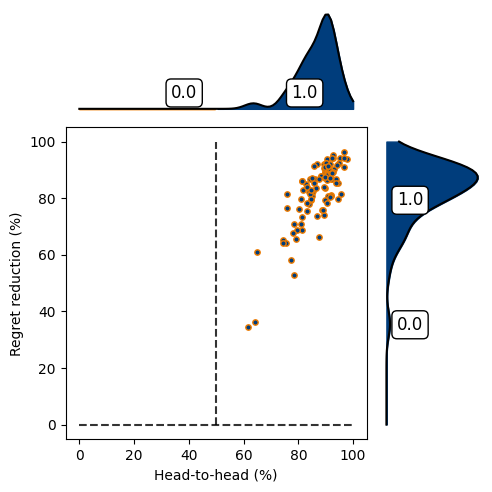

In [23]:
L_N = 3
mu = 0.75
lamb = 0.8
file_name = Result_dir + 'DDR_vs_SPO_mu='+str(mu)+"_lamb="+str(lamb)+"_ante_grid="+str(L_N)
all_x = h2h_ddr_vs_spo_ante[L_N,mu,lamb] * 100
all_y = regret_rd_ddr_vs_spo_ante[L_N,mu,lamb] * 100
Upright_Figure(all_x, all_y, file_name, size = (5, 5), move = [0.35, 0.75, 0.35, 0.75], 
                        ymin = 0, ymax=100,xmin = 0,xmax = 100)